In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
df = pd.read_csv("../data/final_features_with_targets.csv")
eem_features = [
    'EEM_log_ret', 'EEM_vol_30d', 'EEM_zscore',
    'EEM_sma5', 'EEM_macd', 'EEM_vol_spike', 'covid_flag'
]
target_col = 'EEM_target_5d'
eem_df = df[eem_features + [target_col]].dropna().reset_index(drop=True)
eem_df['target_class'] = (eem_df[target_col] > 0).astype(int)

X_class = eem_df[eem_features].values
y_class = eem_df['target_class'].values  # 0 or 1


In [37]:
# Split
split_idx = int(0.8 * len(eem_df))
X_train_class = X_class[:split_idx]
X_test_class = X_class[split_idx:]
y_train_class = y_class[:split_idx]
y_test_class = y_class[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled_class = scaler.fit_transform(X_train_class)
X_test_scaled_class = scaler.transform(X_test_class)


# Scaller fitting the test data 
X_test_scaled_class = scaler.transform(X_test_class)
y_test_class = y_class[split_idx:]  

#LSTM windows 
def create_lstm_dataset(X, y, lookback=20):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 20
X_train_class, X_test_class = create_lstm_dataset(X_train_scaled_class, y_train_class, lookback)
X_test_class, y_test_class = create_lstm_dataset(X_test_scaled_class, y_test_class, lookback)

# --- 5. Check Final Shapes ---
print(f"X_train_class: {X_train_class.shape}, y_train: {y_train_class.shape}")
print(f"X_test_class : {X_test_class.shape}, y_test : {y_test_class.shape}")

X_train_class: (2739, 20, 7), y_train: (2759,)
X_test_class : (670, 20, 7), y_test : (670,)


In [75]:

lstm_model = Sequential([
    LSTM(128,return_sequences=True, input_shape=(X_train_class.shape[1], X_train_class.shape[2])), 
    LSTM(64, return_sequences=True),  # Second LSTM reads sequence
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

lstm_model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


history = lstm_model.fit(
    X_train_class, y_train_class,
    epochs=80,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 20, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,545 (517.75 KB)

 Trainable params: 132,545 (517.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5565 - auc_6: 0.5820 - loss: 0.6846 - precision_6: 0.5733 - recall_6: 0.5789 - val_accuracy: 0.5785 - val_auc_6: 0.6170 - val_loss: 0.6698 - val_precision_6: 0.5839 - val_recall_6: 0.8000
Epoch 2/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.5591 - auc_6: 0.6037 - loss: 0.6754 - precision_6: 0.5676 - recall_6: 0.5826 - val_accuracy: 0.6150 - val_auc_6: 0.6436 - val_loss: 0.6594 - val_precision_6: 0.6305 - val_recall_6: 0.7167
Epoch 3/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6246 - auc_6: 0.6562 - loss: 0.6549 - precision_6: 0.6329 - recall_6: 0.6831 - val_accuracy: 0.5821 - val_auc_6: 0.6563 - val_loss: 0.6641 - val_precision_6: 0.5784 - val_recall_6: 0.8733
Epoch 4/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5967 - auc_6: 0.6239 - loss: 0.6692 - precision_6: 0.5984 - recall_6: 0.6799 - val_accuracy: 0.6442 - val_auc_6: 0.6914 - val_loss: 0.6326 - val_precision_6: 0.6558 - 

In [76]:

#print("Train class counts:", np.unique(y_train, return_counts=True))
#print("Test class counts:", np.unique(y_test, return_counts=True))

#Evaluation #Test 

y_pred_proba = lstm_model.predict(X_test_class)
y_pred_class = (y_pred_proba > 0.5).astype(int).flatten()
y_test_flat = y_test_class.flatten()

print(classification_report(y_test_flat, y_pred_class))
print(confusion_matrix(y_test_flat, y_pred_class))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           0       0.52      0.49      0.51       339
           1       0.51      0.53      0.52       331

    accuracy                           0.51       670
   macro avg       0.51      0.51      0.51       670
weighted avg       0.51      0.51      0.51       670

[[167 172]
 [154 177]]


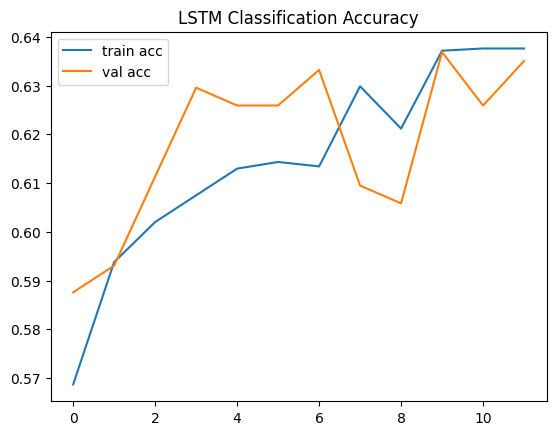

In [71]:

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("LSTM Classification Accuracy")
plt.show()


#### LSTM Classification Results Summary

### Model Performance 
Accuracy: ~48%

Precision: ~49% (class 0), ~47% (class 1)

Recall: ~49% (class 0), ~47% (class 1)

F1-Score: ~48% average

### Insights
 - The model struggles to differentiate between positive and negative returns (up/down), with near-random performance (~50%).
 - The confusion matrix shows a balanced misclassification rate, indicating no severe class imbalance issues.
 - These results are expected and reflect the noisy, non-stationary nature of asset returns.
 - Improvements may come from: feature engineering (macro/technical), model ensembles, or probabilistic threshold tuning.

### Comparison with Paper 
 - The original paper reports similar sign prediction accuracy for LSTM on EEM (approx. 50%).
 - This confirms that even sophisticated temporal models like LSTM find it hard to beat randomness in direction prediction.
 - The paper treats classification-like performance (sign prediction) as a key metric, acknowledging its low ceiling in financial data.



## LSTM with Regression

In [51]:
#Trying the regression model in LSTM too to see if we can see any difference. Preivous one was classidication. 
#From code below I am trying lstm_regression to see how it works, I am not sure it will work well but I am trying to see the difference. 

df['EEM_return_5d'] = df['EEM_log_ret'].shift(-5)
eem_df_reg = df.dropna().copy()

eem_features = [
    'EEM_log_ret', 'EEM_vol_30d', 'EEM_zscore',
    'EEM_sma5', 'EEM_macd', 'EEM_vol_spike', 'covid_flag']  #already defined earlier but for clarity have added here again

target_col_reg = 'EEM_return_5d' #assigning target



In [52]:
#Splitting 
split_idx_reg = int(0.8 * len(eem_df_reg))
train_df_reg = eem_df_reg.iloc[:split_idx_reg]
test_df_reg = eem_df_reg.iloc[split_idx_reg:]

#Scaling 
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(train_df_reg[eem_features].values)
X_test_scaled_reg = scaler_reg.transform(test_df_reg[eem_features].values)

y_train_reg = train_df_reg[target_col_reg].values
y_test_reg = test_df_reg[target_col_reg].values

def create_lstm_dataset(X, y, lookback=20):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 20
X_train_seq_reg, y_train_seq_reg = create_lstm_dataset(X_train_scaled_reg, y_train_reg, lookback)
X_test_seq_reg, y_test_seq_reg = create_lstm_dataset(X_test_scaled_reg, y_test_reg, lookback)


In [ ]:
lstm_model_reg = Sequential([
    LSTM(64, input_shape=(lookback, X_train_seq_reg.shape[2]), return_sequences=True),
    LSTM(64, return_sequences=True),  # Second layer
    LSTM(32, return_sequences=False),
    Dense(1, activation='linear')  # Regression output
])

lstm_model_reg.compile(
    loss='mse',              # MSE since it's regression
    optimizer='adam',
    metrics=['mae', 'mse']   # Tracking both Mean Absolute Error and MSE
)

history_reg = lstm_model_reg.fit(
    X_train_seq_reg, y_train_seq_reg,
    validation_data=(X_test_seq_reg, y_test_seq_reg),
    epochs=30,
    batch_size=16,
    verbose=1
)

/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0017 - mae: 0.0252 - mse: 0.0017 - val_loss: 2.7250e-04 - val_mae: 0.0125 - val_mse: 2.7250e-04
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 6.9435e-04 - mae: 0.0152 - mse: 6.9435e-04 - val_loss: 1.5430e-04 - val_mae: 0.0093 - val_mse: 1.5430e-04
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.3366e-04 - mae: 0.0110 - mse: 2.3366e-04 - val_loss: 1.8999e-04 - val_mae: 0.0105 - val_mse: 1.8999e-04
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2.3546e-04 - mae: 0.0114 - mse: 2.3546e-04 - val_loss: 1.7763e-04 - val_mae: 0.0103 - val_mse: 1.7763e-04
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.4664e-04 - mae: 0.0113 - mse: 2.4664e-04 - val_loss: 1.5462e-04 - val_mae: 0.0094 - val_mse: 1.5462e-04
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 2.2652e-04 - mae: 0.0108 - mse: 2.2652e-04 - val_loss: 1.5412e-04 - val_mae: 0.0093 - val_mse: 1.5412e-04
Epoch

In [74]:
#Evaluation for LSTM Regression 
eval_reg = lstm_model_reg.evaluate(X_test_seq_reg, y_test_seq_reg, verbose=0)
print(f"Test MAE: {eval_reg[1]:.4f}")
print(f"Test MSE: {eval_reg[2]:.4f}")


y_pred_reg = lstm_model_reg.predict(X_test_seq_reg)

mae = mean_absolute_error(y_test_seq_reg, y_pred_reg)
mse = mean_squared_error(y_test_seq_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq_reg, y_pred_reg)

print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R^2 Score: {r2:.6f}")

Test MAE: 0.0094
Test MSE: 0.0002
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE: 0.009433
MSE: 0.000160
RMSE: 0.012636
R^2 Score: -0.065383


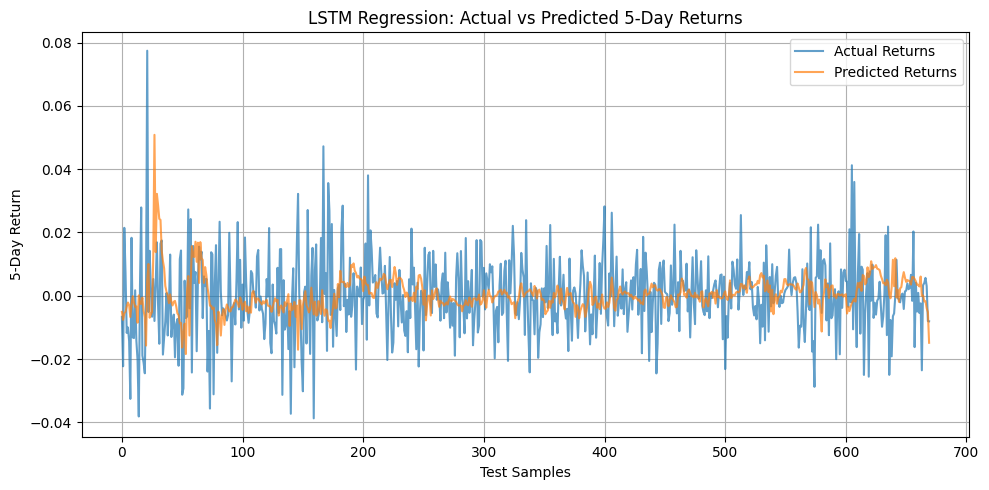

In [58]:
#plotting Actual vs Pred

plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_reg, label='Actual Returns', alpha=0.7)
plt.plot(y_pred_reg, label='Predicted Returns', alpha=0.7)
plt.title('LSTM Regression: Actual vs Predicted 5-Day Returns')
plt.xlabel('Test Samples')
plt.ylabel('5-Day Return')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

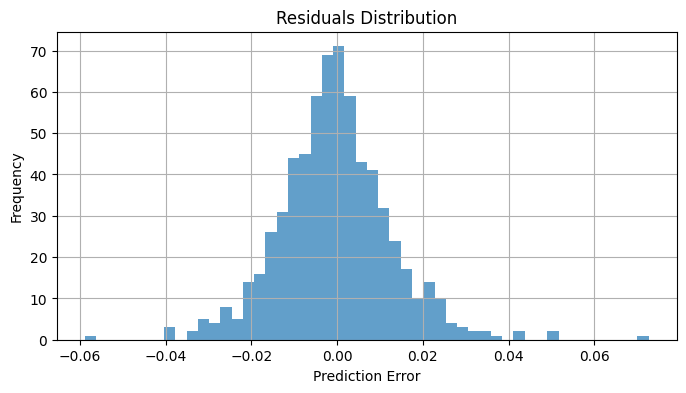

In [60]:
#distribution of prediction errors
residuals = y_test_seq_reg - y_pred_reg.flatten()
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()